In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from rfest import splineLG, splineLNP, splineLNLN
from rfest.utils import fetch_data, split_data, upsample_data
from rfest.utils import get_n_samples, build_design_matrix

import dill as pickle
from tqdm import tqdm
import os
from pathlib import Path

C:\Users\aleks\anaconda3\envs\nds_jax\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def get_stim_spike_data(spikes, stim_table):
    """
    Calculate expected amount of spikes within each stimulus timeframe.
    Gets spike time series and stim_table with indexes of start and end of the stimulus.
    Returns expected spike counts in shape (n_stimuli, n_neurons)
    """
    istim_start = stim_table['start'].values
    istim_end   = stim_table['end'].values
    
    n_neurons, n_times = spikes.shape
    n_stim = len(istim_start)

    stim_spike_data = np.empty((n_stim, n_neurons))
    for i in range(n_stim):
        # cut out spikes outside of trial times
        spikes_frame = spikes[:, istim_start[i]:istim_end[i]]
        # sum over time dimension to get expected spike count within a trial
        stim_spike_data[i] = np.sum(spikes_frame, axis=1) 
    return stim_spike_data


def load_spikes(model_name, fillnan="zeros", data_path = Path("./data/")):
    """
    Expected spike directory: ../data/spikes/
    Fills NaNs in the data with fillnan. Available options:
    - zeros
    - mean
    - median
    
    """  
    spikes = np.load(data_path / f"spikes/spikes_{model_name}.npy")
    n_neurons = spikes.shape[0]
    
    fillvals = {
        "zeros": [0 for _ in range(n_neurons)], 
        "median": np.median(spikes, axis=1), 
        "mean": np.nanmean(spikes, axis=1)
               }
    for neuron in range(n_neurons):
        spikes[neuron, np.isnan(spikes[neuron])] = fillvals[fillnan][neuron]
    return spikes

def shape2str(arr):
    return "(" + "-".join(map(str, arr)) + ")"

In [5]:
spikes_model = "Global_EXC_30Hz_smoothing50ms_causalkernel"
data_path = Path("../../data/")

data = np.load(data_path / "prac2_data.npy", allow_pickle=True).item()

dff = data['dff']
stim = data['stim']
n_stim, dy, dx = stim.shape
frame_shape = (dy, dx)

# load spikes
spikes = load_spikes(spikes_model, data_path = data_path)
n_neurons = spikes.shape[0]

# load spikes within a stimulus frame
stim_spike_data = get_stim_spike_data(spikes, data['stim_table'])

# set most active neurons variable for testing the RFs
most_active = [38, 114,  43,  89,  98, 174, 163,  60,  71, 179]

# building the predictors matrix (stimuli)
X = build_design_matrix(stim.reshape((n_stim, -1)), 1)
print(X.shape)

# stim_spike_data is y, but for each neuron it's different
print(stim_spike_data.shape)
n_stim, n_neurons = stim_spike_data.shape

(8880, 448)
(8880, 189)


### LNP

In [ ]:
dt = 0.25 # 250 ms stimulus
df = [12, 24]
dims = [dy, dx]

X = build_design_matrix(stim.reshape((n_stim, -1)), 1)

w_names = ["w_mle", "w_sta", "w_opt", "w_spl"]
rf_dict = {w_name: [] for w_name in w_names}

for neuron in tqdm(range(n_neurons)):
    y = stim_spike_data[:, neuron]
    model = splineLNP(X, y, dims=dims, dt=dt, df=df, compute_mle=True)
    model.fit(verbose=0, fit_nonlinearity=True)
    for w_name in w_names:
        rf_dict[w_name].append(model.__dict__[w_name])
        
print("Saving outputs...")
for w_name in w_names:
    rf_dict[w_name] = np.array(rf_dict[w_name])
    fname = f"rf_splineLNP-{w_name}_spikes-{spikes_model}.npy"
    np.save(data_path / "rf" / fname, rf_dict[w_name])

In [46]:
dt = 0.25 # 250 ms stimulus
delay = 6
df = [delay * 2, 12, 24]
dims = [delay, dy, dx]

X = build_design_matrix(stim.reshape((n_stim, -1)), delay)

w_names = ["w_mle", "w_sta", "w_opt", "w_spl"]
rf_dict = {w_name: [] for w_name in w_names}

for neuron in tqdm(range(n_neurons)):
    y = stim_spike_data[:, neuron]
    model = splineLNP(X, y, dims=dims, dt=dt, df=df, compute_mle=True)
    model.fit(verbose=0, fit_nonlinearity=True, fit_history_filter=True)
    for w_name in w_names:
        rf_dict[w_name].append(model.__dict__[w_name])
        
print("Saving outputs...")
for w_name in w_names:
    rf_dict[w_name] = np.array(rf_dict[w_name])
    fname = f"rf_splineLNP-{w_name}-history{delay}_spikes-{spikes_model}.npy"
    np.save(data_path / "rf" / fname, rf_dict[w_name])

  0%|                                                                                          | 0/189 [00:26<?, ?it/s]


TypeError: unsupported operand type(s) for @: 'NoneType' and 'NoneType'

In [146]:
%%time
neuron = 38
y = stim_spike_data[:, neuron]
model = splineLNP(X, y, dims=dims, dt=dt, df=df, compute_mle=True)
model.fit(verbose=0)

for key, w in model.__dict__.items():
    if "w_" in key:
        try:           
            plt.title(key)
            plt.imshow(w.reshape(frame_shape), cmap='RdBu')
            plt.show()
        except:
            continue

In [53]:
%%time
delay = 6
dt = 0.25
df = [delay * 2, 12, 24]
dims = [delay, dy, dx]

X = build_design_matrix(stim.reshape((n_stim, -1)), delay)
print(X.shape)
print(np.prod(dims))

(8880, 2688)
2688
CPU times: total: 188 ms
Wall time: 185 ms


In [58]:
%%time

neuron = 38
y = stim_spike_data[:, neuron]
model = splineLNP(X, y, dims=dims, dt=dt, df=df, compute_mle=True)
model.fit(fit_nonlinearity=True)

Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            3.391        3095.925        
100          8.640        1180.601        
200          13.885       995.951         
300          19.290       843.108         
400          24.678       703.081         
500          29.936       574.457         
600          35.125       457.998         
700          40.459       354.544         
800          45.742       264.051         
900          51.076       185.622         
1000         56.400       117.948         
1100         61.791       59.600          
1200         67.046       9.184           
1300         72.424       -34.515         
1400         77.576       -72.691         
1500         82.880       -106.213        
1600         88.189       -135.814        
1700         93.374       -162.104        
1800         98.892       -185.628        
1900         104.305      -206.781        
2000         109.524      -225.894        
2100         114.913  

In [59]:
for key, w in model.__dict__.items():
    if "w_" in key:
        print(key)
        try:           
            print(w.shape)
        except:
            continue

w_spl
(2688,)
w_opt
(2688,)
w_stc
w_sta
(2688,)
w_mle
(2688,)


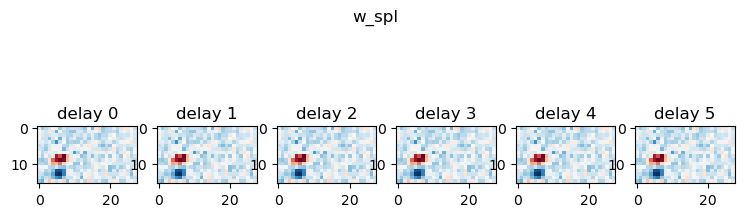

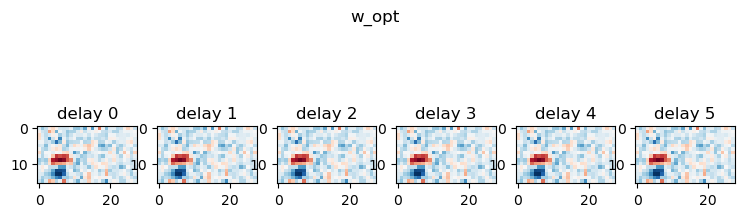

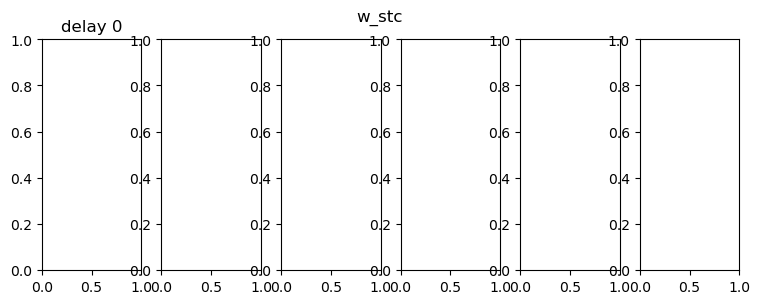

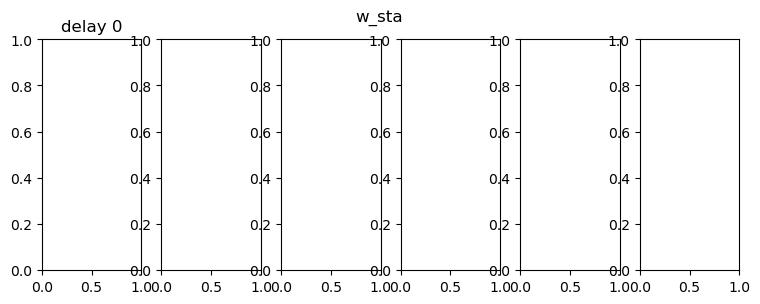

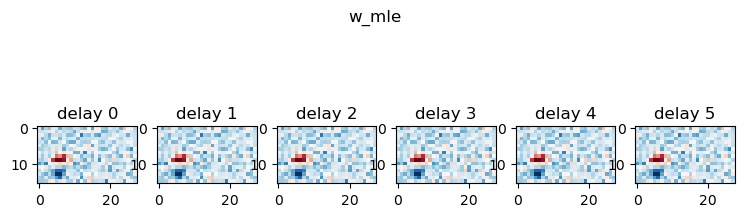

In [60]:
for key, w in model.__dict__.items():
    if "w_" in key:    
        try:
            fig, axes = plt.subplots(1, delay, figsize=(9, 3))
            plt.suptitle(key)
            for i in range(delay):
                axes[i].set_title(f"delay {i}")
                axes[i].imshow(w.reshape(dims)[delay], cmap='RdBu')
            plt.show()
        except:
            continue


#### Saving RFs for LNLN in the correct shape

In [65]:
for w_name in w_names:
    fname = f"rf_LNLN-{w_name}_spikes-{spikes_model}.npy"
    w = np.load(data_path / "rf" / fname)
    print(w.shape)
    if w_name == "w_opt":
        w = w.reshape((-1, *frame_shape, w.shape[-1])) # because n_subunits
    else:
        w = w.reshape((-1, *frame_shape))
    print(w.shape)
    np.save(data_path / "rf" / fname, w)

(189, 448)
(189, 16, 28)
(189, 448)
(189, 16, 28)
(189, 448, 5)
(189, 16, 28, 5)
(189, 448)
(189, 16, 28)


#### Save "best RF" - sum of subunits

In [105]:
w_name = "w_opt"
fname = f"rf_LNLN-{w_name}_spikes-{spikes_model}.npy"
w = np.load(data_path / "rf" / fname)

w_name_new = "w_best"
fname_new = f"rf_LNLN-{w_name_new}_spikes-{spikes_model}.npy"
np.save(data_path / "rf" / fname_new, w.sum(axis=-1))

#### Plot all of them - subunits

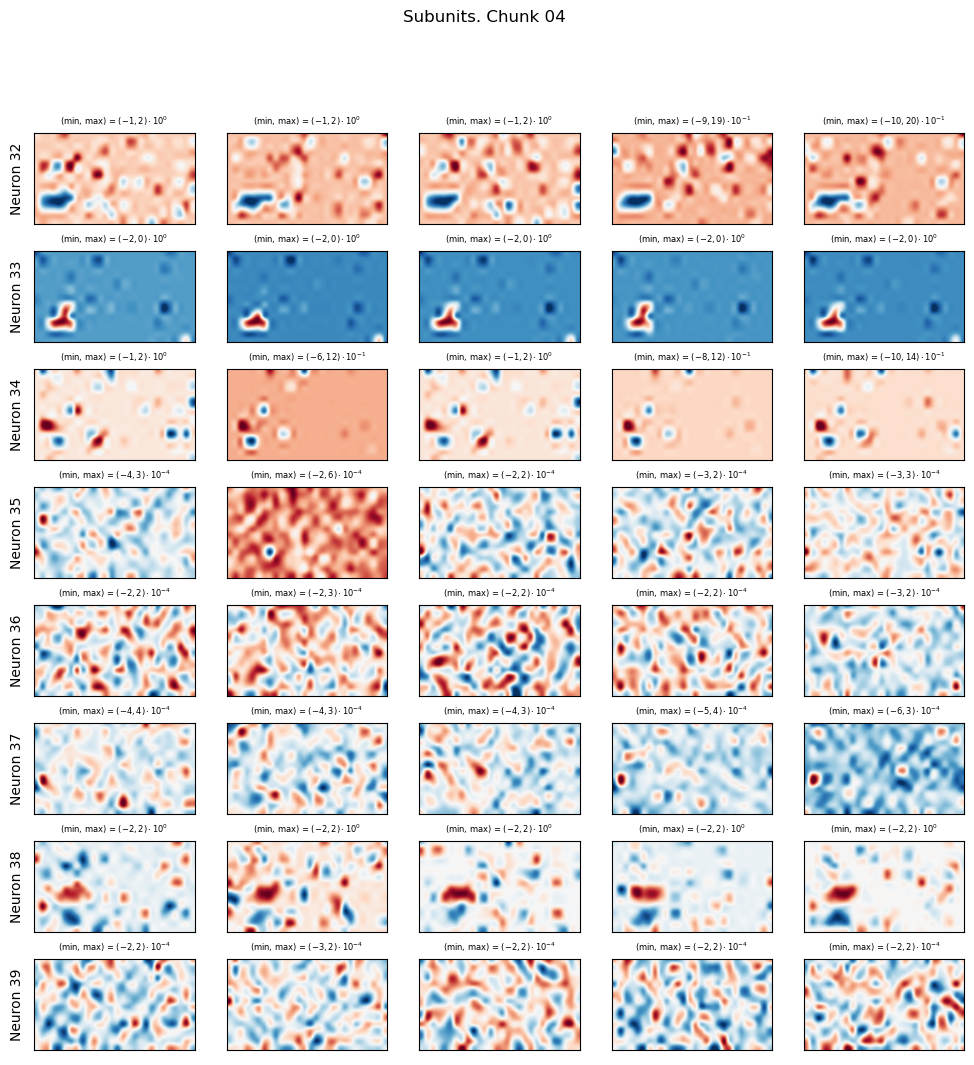

CPU times: total: 1min 31s
Wall time: 1min 32s


In [104]:
%%time
smoothing = "spline16"
save_path = Path("../../img") / "rf" / "LNLN" / f"subunits-smoothing-{smoothing}"
os.makedirs(save_path, exist_ok=True)

w_name = "w_opt"
fname = f"rf_LNLN-{w_name}_spikes-{spikes_model}.npy"
w = np.load(data_path / "rf" / fname)

n_subunits = w.shape[-1]

n_batch = 8
n_chunks = int(np.ceil(n_neurons / n_batch))

for chunk in range(n_chunks):
    
    neurons_list = np.arange(n_batch * chunk, n_batch * (chunk + 1))  
    
    n = len(neurons_list)
    fig, axes = plt.subplots(n, n_subunits, figsize=(12, 1.5 * n))
    plt.suptitle(f"Subunits. Chunk {chunk:02d}")
    
    for i_neuron in range(n):
        neuron = neurons_list[i_neuron]
        for subunit in range(n_subunits):
            ax = axes[i_neuron, subunit]
            if i == 0:
                ax.set_title(f"Subunit {subunit}")
            if subunit == 0:
                ax.set_ylabel(f"Neuron {neuron}")
            try:
                w_plot = w[neuron, :, :, subunit]
                w_min, w_max = np.min(w_plot), np.max(w_plot)
                minbase10 = int(np.floor(np.log10(np.abs(w_min))))
                ax.imshow(w_plot, cmap='RdBu', interpolation=smoothing)
                ax.set_title(f"(min, max) = $({{{w_min / 10 ** minbase10:.0f}}}, {{{w_max / 10 ** minbase10:.0f}}})\cdot10^{{{minbase10}}}$", fontdict={'fontsize': 6})
                ax.set_xticks([])
                ax.set_yticks([])
            except:
                continue
    
    
    figname = f"subunits_segment{chunk:02d}.png"
    plt.savefig(save_path / figname, bbox_inches='tight', dpi=150)
    if chunk == 4:
        plt.show()
    else:
        plt.close()


#### STA, MLE, SPL

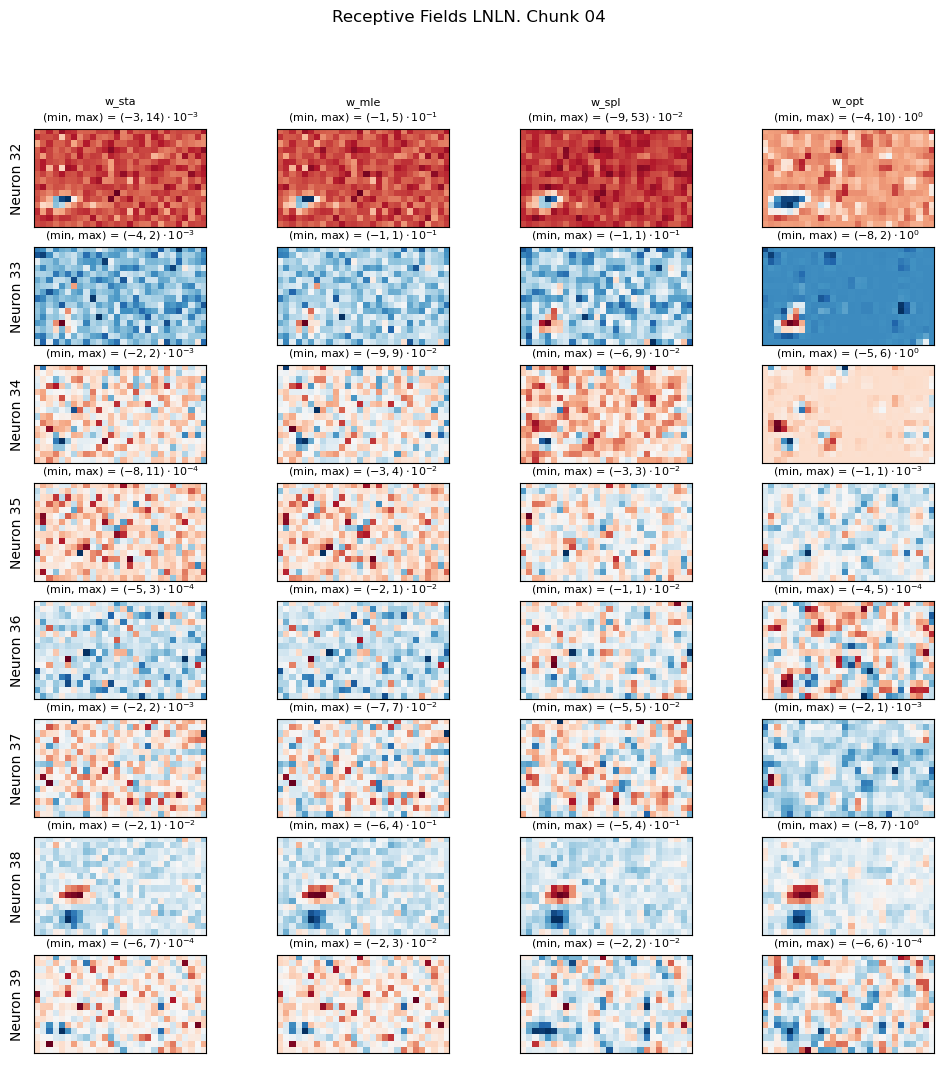

In [102]:
%%time
smoothing = "none"
save_path = Path("../../img") / "rf" / "LNLN" / f"sta-mle-spl-subunitsum-smoothing-{smoothing}"
os.makedirs(save_path, exist_ok=True)


w_names = ["w_sta", "w_mle", "w_spl", "w_opt"]
w_dict = {}
for w_name in w_names:
    fname = f"rf_LNLN-{w_name}_spikes-{spikes_model}.npy"
    w = np.load(data_path / "rf" / fname)
    w_dict[w_name] = w

n_batch = 8
n_chunks = int(np.ceil(n_neurons / n_batch))

for chunk in range(n_chunks):
    
    neurons_list = np.arange(n_batch * chunk, n_batch * (chunk + 1))  
    
    n = len(neurons_list)
    fig, axes = plt.subplots(n, len(w_names), figsize=(12, 1.5 * n))
    plt.suptitle(f"Receptive Fields LNLN. Chunk {chunk:02d}")
    
    for i in range(n):
        neuron = neurons_list[i]
        for j in range(len(w_names)):
            w_name = w_names[j]
            ax = axes[i, j]
            if j == 0:
                ax.set_ylabel(f"Neuron {neuron}")
            if w_name == "w_opt":
                w = w_dict[w_name].sum(axis=-1) # sum over subunits
            else:
                w = w_dict[w_name]
            try:
                w_plot = w[neuron, :, :]
                w_min, w_max = np.min(w_plot), np.max(w_plot)
                minbase10 = int(np.floor(np.log10(np.abs(w_min))))
                ax.imshow(w_plot, cmap='RdBu', interpolation=smoothing)
                titlestr = f"(min, max) = $({{{w_min / 10 ** minbase10:.0f}}}, {{{w_max / 10 ** minbase10:.0f}}})\cdot10^{{{minbase10}}}$"
                if i == 0:
                    titlestr = w_name + "\n" + titlestr
                ax.set_title(titlestr, fontdict={'fontsize': 8})
                ax.set_xticks([])
                ax.set_yticks([])
            except:
                continue
    
    
    figname = f"rf_segment{chunk:02d}.png"
    plt.savefig(save_path / figname, bbox_inches='tight', dpi=150)
    if chunk == 4:
        plt.show()
    else:
        plt.close()

In [132]:
neuron = 38
y = stim_spike_data[:, neuron]
model = splineLNP(X, y, dims=dims, dt=dt, df=df, compute_mle=True)
model.fit(fit_nonlinearity=True)

Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            0.691        1739.379        
100          1.499        -3246.195       
200          2.310        -5552.973       
300          3.125        -6678.003       
400          3.943        -7224.993       
500          4.667        -7486.709       
600          5.353        -7611.381       
700          6.194        -7673.524       
800          7.013        -7708.988       
900          7.920        -7733.904       
1000         8.614        -7754.813       
1100         9.456        -7774.159       
1200         10.224       -7792.740       
1300         11.066       -7810.774       
1400         11.890       -7828.338       
1500         12.517       -7845.445       
1600         13.365       -7862.086       
1700         14.176       -7878.246       
1800         14.977       -7893.911       
1900         15.661       -7909.078       
2000         16.337       -7923.736       
2100         16.962   

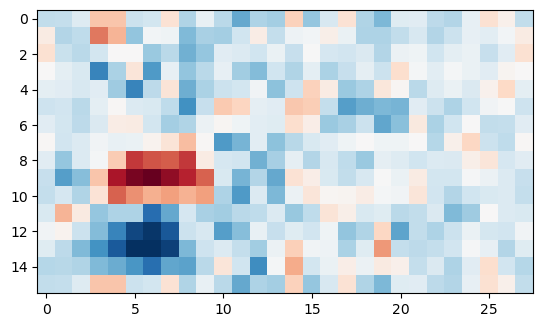

In [133]:
plt.imshow(model.w_opt.reshape(frame_shape), cmap='RdBu')

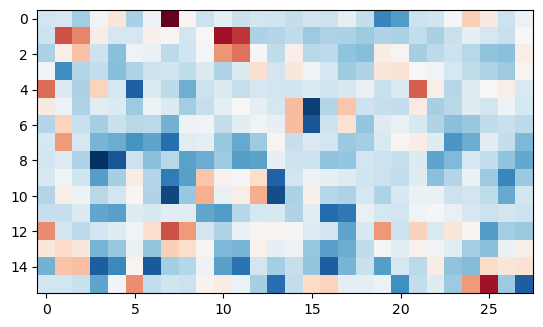

In [129]:
plt.imshow(model.w_opt.reshape(frame_shape), cmap='RdBu')

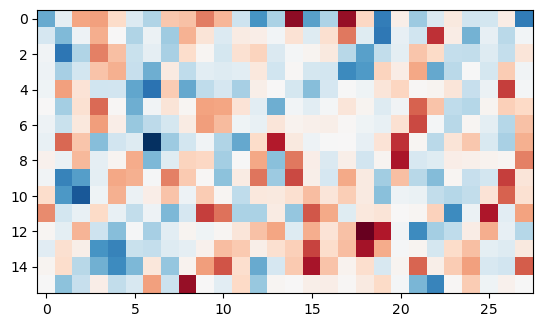

In [115]:
plt.imshow(rfs[0].reshape(dims)[0], cmap='RdBu')

In [79]:
neuron = most_active[4]
y = stim_spike_data[:, neuron]
lnp = splineLNLN(X, y, dims=dims, df=df, dt=dt)
lnp.fit(verbose=0)

In [85]:
lnp.w_opt.shape

(448, 2)

Text(0.5, 1.0, 'Neuron #98')

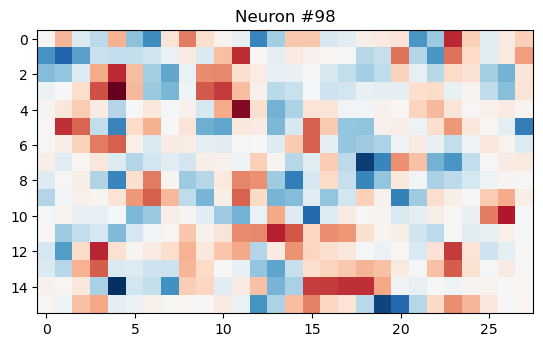

In [81]:
plt.imshow(lnp.w_opt[:, 0].reshape(frame_shape), cmap='RdBu')
plt.title(f"Neuron #{neuron}")

Text(0.5, 1.0, 'Neuron #98')

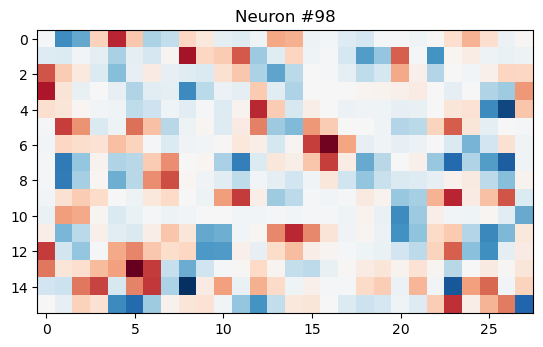

In [82]:
plt.imshow(lnp.w_opt[:, 1].reshape(frame_shape), cmap='RdBu')
plt.title(f"Neuron #{neuron}")

Text(0.5, 1.0, 'Neuron #98')

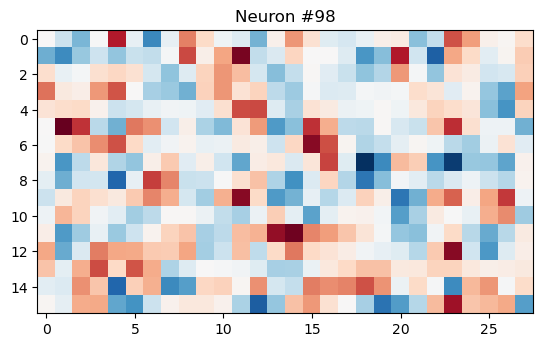

In [84]:
plt.imshow(lnp.w_opt.sum(axis=1).reshape(frame_shape), cmap='RdBu')
plt.title(f"Neuron #{neuron}")

### SplineLNLN

In [ ]:
dt = 1 / 30.1458
df = [12, 24]
dims = [dy, dx]

X = build_design_matrix(stim.reshape((n_stim, -1)), 1)

rf_model = f"splineLNLN_df-{shape2str(df)}"

w_opt_list = []

for neuron in tqdm(range(n_neurons)):
    y = stim_spike_data[:, neuron]
    model = splineLNLN(X, y, dims=dims, dt=dt, df=df)
    model.fit(verbose=0)
    w_opt_list.append(model.w_opt)
    
lnln_w_opt = np.array(w_opt_list)
np.save(data_path / "rf" / "splineLNLN_w_opt.npy", lnln_w_opt)

##### from the prev notebook

In [ ]:
dt = 1 / 30.1458
df = [13, 21]
dims = frame_shape

fit_history_filter = False
w_list = []

for neuron in tqdm(most_active):

    #(X_train, y_train), (X_dev, y_dev), (X_test, y_test), dt = prepare_data(stim, triggertime, traces[neuron], tracetime, dims)  
    
    model = splineLNLN(X_train, np.maximum(y_train, 0), dims=dims, dt=dt, df=df)
    
    # prepare the save path for the model dump
    model_name = model.__class__.__name__
    path = data_path / "rf" / f"dim-{shape2str(dims)}_df-{shape2str(df)}" / model_name
    fname = f"rf_cell{neuron:03d}.npy"  
    os.makedirs(path, exist_ok=True)
    
    if fit_history_filter: 
        model.initialize_history_filter(dims=dims[0], df=df[0]) 
    
    model.fit(extra={'X': X_dev, 'y': np.maximum(y_dev, 0)}, metric='corrcoef', 
         num_subunits=3, num_iters=3000, verbose=0, tolerance=10,
         beta=0.25, step_size=0.01, fit_history_filter=fit_history_filter)
    
    np.save(path / fname, model.w_opt)
    w_list.append(model.w_opt)  